# Imports

In [1]:
from pathlib import Path
import numpy as np
import torch
import math
from tqdm import tqdm
from torchvision.datasets import CocoDetection
import matplotlib.pyplot as plt
import torchvision

/home/avashchilko/abbyy9sem/course_cvdl/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from abbyy_course_cvdl_t3.coco_text import COCO_Text
from abbyy_course_cvdl_t3 import coco_evaluation
from abbyy_course_cvdl_t3.utils import evaluate_ap_from_cocotext_json
from abbyy_course_cvdl_t3.utils import dump_detections_to_cocotext_json

In [3]:
cd ../task2

/home/avashchilko/abbyy9sem/course_cvdl/task2


In [4]:
import abbyy_course_cvdl_t2
from abbyy_course_cvdl_t2.convert import PointsToObjects, ObjectsToPoints
from abbyy_course_cvdl_t2.impl.train import train
from abbyy_course_cvdl_t2.impl.data import CocoTextDetection, CocoDetectionPrepareTransform
from abbyy_course_cvdl_t2.network import CenterNet
from abbyy_course_cvdl_t2.loss import CenterNetLoss

In [5]:
cd ../task3

/home/avashchilko/abbyy9sem/course_cvdl/task3


In [6]:
device = torch.device('cuda:2')

# Data

In [7]:
base = Path("/home/avashchilko/coco2014")
anno_path = base / 'cocotext.v2.json'
images_path = base / 'train'

assert anno_path.exists(), "Set your own path to annotation"
assert images_path.exists(), "Set your own path to images"


In [8]:
ct = COCO_Text(anno_path)

loading annotations into memory...
0:00:01.915656
creating index...
index created!


In [9]:
def draw_boxes(image_np, yc_t, xc_t, hy_t, wx_t, color=(0, 255, 0), thick=1):
    img = np.array(image_np)
    num_boxes = len(yc_t)
    val = np.array(color)
    for idx in range(num_boxes):
        yc = yc_t[idx]
        xc = xc_t[idx]
        hy = hy_t[idx]
        wx = wx_t[idx]
        img[
                yc - hy//2 - thick : yc - hy//2 + thick, 
                xc - wx//2 : xc + wx//2, 
        ] = val
        img[
                yc + hy//2 - thick : yc + hy//2 + thick, 
                xc - wx//2 : xc + wx//2, 
        ] = val

        img[
                yc - hy//2 : yc + hy//2, 
                (xc - wx//2 - thick): (xc - wx//2 + thick), 
        ] = val
        img[
                yc - hy//2 : yc + hy//2, 
                xc + wx//2 - thick: xc + wx//2 + thick, 
        ] = val
    return img
        
        

In [10]:
n_classes = 2
input_shape = (512, 512)

In [11]:
ds_train = CocoTextDetection(
    images_path,
    anno_path,
    transforms=CocoDetectionPrepareTransform(size=input_shape, #ids_map = {1: 0, 0: 0}
),
    area_fraction_threshold=1/32/32
)

In [12]:
ds_val = CocoTextDetection(
    images_path,
    anno_path,
    transforms=CocoDetectionPrepareTransform(size=input_shape, #ids_map = {1: 0, 0: 0}
    ),
    area_fraction_threshold=1/32/32,
    split='val'
)

In [13]:
x, y = ds_train[6]

In [14]:
y[:10]

tensor([[267.7867, 121.1200,  25.0667,  26.8800,   1.0000,   1.0000],
        [263.0400, 313.5600,  23.0400,  39.7600,   1.0000,   1.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000]])

In [15]:
trainloader = torch.utils.data.DataLoader(
    ds_train, batch_size=2, shuffle=True
)

In [16]:
valloader = torch.utils.data.DataLoader(
    ds_val, batch_size=1, shuffle=False
)

# Learning

In [17]:
net = CenterNet(pretrained="resnet34", head_kwargs={'c_classes': n_classes}, nms_kwargs={'kernel_size': 5})
crit = CenterNetLoss(obj_to_points=ObjectsToPoints(num_classes=n_classes, hw=128))#, l_size_lambda=3)

/home/avashchilko/abbyy9sem/course_cvdl/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/avashchilko/abbyy9sem/course_cvdl/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /home/avashchilko/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|███████████████████████████████████████████████████████████████████| 83.3M/83.3M [00:01<00:00, 75.4MB/s]


In [18]:
net = train(ds_train, net=net, criterion=crit, batch_size=64, epochs=100, device=torch.device(device), lr=1e-3)

epoch 0|0; total loss:109.83483123779297
last losses: [3293.9833984375, 0.23417973518371582, 0.8271242380142212]
epoch 0|30; total loss:107.14881896972656
last losses: [2.6929287910461426, 0.2515536844730377, 0.42369839549064636]
epoch 0|60; total loss:3.289069175720215
last losses: [2.9655344486236572, 0.30696725845336914, 0.6085044741630554]
epoch 0|90; total loss:3.0845324993133545
last losses: [2.1765401363372803, 0.272307813167572, 0.5913708209991455]
epoch 0|120; total loss:2.7831315994262695
last losses: [2.0610857009887695, 0.2652043104171753, 0.6122362017631531]
epoch 0|150; total loss:2.712268829345703
last losses: [1.984063982963562, 0.25473082065582275, 0.638269305229187]
epoch 0|180; total loss:2.5642247200012207
last losses: [1.906809687614441, 0.27920886874198914, 0.4826742708683014]
epoch 0|210; total loss:2.488767623901367
last losses: [1.6050145626068115, 0.236546128988266, 0.4985955059528351]
epoch 0|240; total loss:2.3846898078918457
last losses: [1.5459015369415283

epoch 7|30; total loss:0.9990078210830688
last losses: [0.5034539699554443, 0.1689390242099762, 0.1422303169965744]
epoch 7|60; total loss:1.0267996788024902
last losses: [0.6186571717262268, 0.21187040209770203, 0.3093568980693817]
epoch 7|90; total loss:0.9837862253189087
last losses: [0.6775798797607422, 0.2166796773672104, 0.1742650717496872]
epoch 7|120; total loss:1.0384851694107056
last losses: [0.7178418636322021, 0.23572614789009094, 0.23589234054088593]
epoch 7|150; total loss:1.0878229141235352
last losses: [0.6609970927238464, 0.19239690899848938, 0.19437937438488007]
epoch 7|180; total loss:1.0694427490234375
last losses: [0.4953739643096924, 0.16174209117889404, 0.1653342992067337]
epoch 7|210; total loss:1.0651143789291382
last losses: [0.8466111421585083, 0.23832100629806519, 0.2801629304885864]
epoch 7|240; total loss:1.021145224571228
last losses: [0.6842789053916931, 0.2077978551387787, 0.19279518723487854]
epoch 7|270; total loss:1.068375825881958
last losses: [0.74

epoch 14|0; total loss:0.022657504305243492
last losses: [0.28116193413734436, 0.17845886945724487, 0.22010430693626404]
epoch 14|30; total loss:0.5946285724639893
last losses: [0.2577159106731415, 0.15104228258132935, 0.1483869105577469]
epoch 14|60; total loss:0.5732029676437378
last losses: [0.3148030638694763, 0.18740931153297424, 0.17484992742538452]
epoch 14|90; total loss:0.5759972333908081
last losses: [0.32666540145874023, 0.2063513994216919, 0.21996459364891052]
epoch 14|120; total loss:0.5951241254806519
last losses: [0.22733169794082642, 0.15384609997272491, 0.11436279118061066]
epoch 14|150; total loss:0.582714319229126
last losses: [0.29898518323898315, 0.19355860352516174, 0.1463826596736908]
epoch 14|180; total loss:0.6366276144981384
last losses: [0.3229854106903076, 0.17654329538345337, 0.13202400505542755]
epoch 14|210; total loss:0.6351441144943237
last losses: [0.27252084016799927, 0.15203168988227844, 0.11160938441753387]
epoch 14|240; total loss:0.662418663501739

epoch 20|270; total loss:0.472308874130249
last losses: [0.1531641036272049, 0.138196662068367, 0.09162446856498718]
epoch 21|0; total loss:0.015160664916038513
last losses: [0.17647655308246613, 0.17179186642169952, 0.10655152797698975]
epoch 21|30; total loss:0.4351446330547333
last losses: [0.140117809176445, 0.15353935956954956, 0.08306466788053513]
epoch 21|60; total loss:0.4467581808567047
last losses: [0.13598152995109558, 0.17085078358650208, 0.12287629395723343]
epoch 21|90; total loss:0.443740576505661
last losses: [0.18132221698760986, 0.19141604006290436, 0.1175667941570282]
epoch 21|120; total loss:0.4501819610595703
last losses: [0.16897036135196686, 0.15252482891082764, 0.1017834022641182]
epoch 21|150; total loss:0.4705963134765625
last losses: [0.1799885332584381, 0.19542263448238373, 0.10446585714817047]
epoch 21|180; total loss:0.4509522616863251
last losses: [0.1453162431716919, 0.1327892243862152, 0.1248842403292656]
epoch 21|210; total loss:0.4558362364768982
last

epoch 27|240; total loss:0.4358404874801636
last losses: [0.13032910227775574, 0.13462133705615997, 0.09187746047973633]
epoch 27|270; total loss:0.41154244542121887
last losses: [0.1912824809551239, 0.17251676321029663, 0.11222024261951447]
epoch 28|0; total loss:0.014580132439732552
last losses: [0.13704855740070343, 0.17766374349594116, 0.12269165366888046]
epoch 28|30; total loss:0.37004518508911133
last losses: [0.10836301743984222, 0.18064303696155548, 0.10486159473657608]
epoch 28|60; total loss:0.36855265498161316
last losses: [0.09628236293792725, 0.15505367517471313, 0.08529265224933624]
epoch 28|90; total loss:0.3742302656173706
last losses: [0.12603922188282013, 0.1567710041999817, 0.09320277720689774]
epoch 28|120; total loss:0.36754724383354187
last losses: [0.11223041266202927, 0.14361126720905304, 0.09542489051818848]
epoch 28|150; total loss:0.3510023355484009
last losses: [0.10112236440181732, 0.15064725279808044, 0.08698461949825287]
epoch 28|180; total loss:0.380108

epoch 34|210; total loss:0.2931336760520935
last losses: [0.08665656298398972, 0.1409817934036255, 0.09776294976472855]
epoch 34|240; total loss:0.281757652759552
last losses: [0.0659593865275383, 0.12101034820079803, 0.07493402808904648]
epoch 34|270; total loss:0.29789501428604126
last losses: [0.078139528632164, 0.13845480978488922, 0.11910317838191986]
epoch 35|0; total loss:0.010450783185660839
last losses: [0.07124727964401245, 0.13568828999996185, 0.10658787935972214]
epoch 35|30; total loss:0.30314144492149353
last losses: [0.07997114956378937, 0.14823271334171295, 0.08458363264799118]
epoch 35|60; total loss:0.2985040247440338
last losses: [0.046939268708229065, 0.1364888995885849, 0.08522539585828781]
epoch 35|90; total loss:0.2988852262496948
last losses: [0.06022604554891586, 0.14588670432567596, 0.10032203793525696]
epoch 35|120; total loss:0.30261918902397156
last losses: [0.05043425410985947, 0.13417764008045197, 0.07912088185548782]
epoch 35|150; total loss:0.2965867221

epoch 41|150; total loss:0.2667080760002136
last losses: [0.09024357795715332, 0.14778000116348267, 0.07665017992258072]
epoch 41|180; total loss:0.2681831121444702
last losses: [0.07057122886180878, 0.13737531006336212, 0.07500465959310532]
epoch 41|210; total loss:0.26133203506469727
last losses: [0.07278679311275482, 0.12249423563480377, 0.07247728109359741]
epoch 41|240; total loss:0.257941871881485
last losses: [0.05245477706193924, 0.13207830488681793, 0.07588200271129608]
epoch 41|270; total loss:0.2633320689201355
last losses: [0.0827568769454956, 0.15001177787780762, 0.09658996760845184]
epoch 42|0; total loss:0.009960200637578964
last losses: [0.0514376275241375, 0.1484970897436142, 0.09887130558490753]
epoch 42|30; total loss:0.2558138370513916
last losses: [0.043939098715782166, 0.13577714562416077, 0.0669456422328949]
epoch 42|60; total loss:0.2568230628967285
last losses: [0.0557413324713707, 0.1405680924654007, 0.07252948731184006]
epoch 42|90; total loss:0.2657717168331

epoch 48|90; total loss:0.22836606204509735
last losses: [0.047318555414676666, 0.12109986692667007, 0.08465837687253952]
epoch 48|120; total loss:0.230863556265831
last losses: [0.05274388939142227, 0.132463276386261, 0.0834597647190094]
epoch 48|150; total loss:0.22693729400634766
last losses: [0.04944644868373871, 0.1033172756433487, 0.07674319297075272]
epoch 48|180; total loss:0.22118040919303894
last losses: [0.03341192379593849, 0.1060878336429596, 0.07856889069080353]
epoch 48|210; total loss:0.22605635225772858
last losses: [0.060410209000110626, 0.15111926198005676, 0.08091014623641968]
epoch 48|240; total loss:0.23271828889846802
last losses: [0.0610523521900177, 0.13415032625198364, 0.09400013089179993]
epoch 48|270; total loss:0.23923255503177643
last losses: [0.05257986858487129, 0.14417222142219543, 0.08185744285583496]
epoch 49|0; total loss:0.008268716745078564
last losses: [0.05922568216919899, 0.11038084328174591, 0.07845497131347656]
epoch 49|30; total loss:0.248513

epoch 55|30; total loss:0.20086686313152313
last losses: [0.03030233457684517, 0.08975303918123245, 0.06490365415811539]
epoch 55|60; total loss:0.19381318986415863
last losses: [0.017061173915863037, 0.09006960690021515, 0.054946720600128174]
epoch 55|90; total loss:0.1994074434041977
last losses: [0.026311401277780533, 0.1009606122970581, 0.0662345215678215]
epoch 55|120; total loss:0.2003997415304184
last losses: [0.029757408425211906, 0.10110282152891159, 0.06590196490287781]
epoch 55|150; total loss:0.20032715797424316
last losses: [0.03590209037065506, 0.08091558516025543, 0.05285758897662163]
epoch 55|180; total loss:0.20053009688854218
last losses: [0.029127180576324463, 0.11199717223644257, 0.06832677125930786]
epoch 55|210; total loss:0.19582420587539673
last losses: [0.03589845076203346, 0.10852816700935364, 0.06211533397436142]
epoch 55|240; total loss:0.1968221217393875
last losses: [0.02252829447388649, 0.11049787700176239, 0.06977972388267517]
epoch 55|270; total loss:0.

epoch 61|270; total loss:0.17345106601715088
last losses: [0.018036039546132088, 0.0819055587053299, 0.05262654274702072]
epoch 62|0; total loss:0.00603882921859622
last losses: [0.018400494009256363, 0.09726623445749283, 0.06549812853336334]
epoch 62|30; total loss:0.18413852155208588
last losses: [0.03747095912694931, 0.0844322219491005, 0.05776169151067734]
epoch 62|60; total loss:0.1921931505203247
last losses: [0.024008752778172493, 0.09147756546735764, 0.061364270746707916]
epoch 62|90; total loss:0.18149308860301971
last losses: [0.023475678637623787, 0.0926215872168541, 0.05432300642132759]
epoch 62|120; total loss:0.1734539121389389
last losses: [0.02301573008298874, 0.09878799319267273, 0.06645780801773071]
epoch 62|150; total loss:0.18724173307418823
last losses: [0.0213019959628582, 0.09107090532779694, 0.0579521581530571]
epoch 62|180; total loss:0.1747802048921585
last losses: [0.026033872738480568, 0.10360180586576462, 0.067367322742939]
epoch 62|210; total loss:0.183374

epoch 68|210; total loss:0.15743882954120636
last losses: [0.013139959424734116, 0.08035317063331604, 0.050325699150562286]
epoch 68|240; total loss:0.1523275226354599
last losses: [0.019579323008656502, 0.0889442041516304, 0.061915744096040726]
epoch 68|270; total loss:0.16496124863624573
last losses: [0.02910657227039337, 0.06530793756246567, 0.05011430010199547]
epoch 69|0; total loss:0.004957359284162521
last losses: [0.0184438768774271, 0.08086470514535904, 0.04941219836473465]
epoch 69|30; total loss:0.15377043187618256
last losses: [0.021781979128718376, 0.06837699562311172, 0.04358474165201187]
epoch 69|60; total loss:0.16297630965709686
last losses: [0.0218417476862669, 0.08346955478191376, 0.05088314786553383]
epoch 69|90; total loss:0.15501047670841217
last losses: [0.01601259410381317, 0.08105925470590591, 0.06663153320550919]
epoch 69|120; total loss:0.1464700996875763
last losses: [0.018149642273783684, 0.06927312910556793, 0.05019371584057808]
epoch 69|150; total loss:0.

epoch 75|150; total loss:0.11648102849721909
last losses: [0.003864468540996313, 0.07512923330068588, 0.05653644725680351]
epoch 75|180; total loss:0.11600708961486816
last losses: [0.005266677588224411, 0.0685751736164093, 0.06850447505712509]
epoch 75|210; total loss:0.11421393603086472
last losses: [0.006985697895288467, 0.0658702403306961, 0.048141419887542725]
epoch 75|240; total loss:0.11558613926172256
last losses: [0.009696034714579582, 0.07556035369634628, 0.04588581249117851]
epoch 75|270; total loss:0.11686203628778458
last losses: [0.0059378379955887794, 0.05987280607223511, 0.040455128997564316]
epoch 76|0; total loss:0.0038448679260909557
last losses: [0.003460919251665473, 0.06822332739830017, 0.04366178810596466]
epoch 76|30; total loss:0.11680211126804352
last losses: [0.01023031584918499, 0.05216673016548157, 0.04405098408460617]
epoch 76|60; total loss:0.11694352328777313
last losses: [0.0035073210019618273, 0.05142813175916672, 0.06350167095661163]
epoch 76|90; tota

epoch 82|60; total loss:0.1303686946630478
last losses: [0.011186055839061737, 0.058560509234666824, 0.04692443460226059]
epoch 82|90; total loss:0.13450346887111664
last losses: [0.01268315315246582, 0.06530418992042542, 0.06263671815395355]
epoch 82|120; total loss:0.13724370300769806
last losses: [0.007474417798221111, 0.07289864122867584, 0.060412317514419556]
epoch 82|150; total loss:0.12557661533355713
last losses: [0.008600921370089054, 0.06487210094928741, 0.04549417272210121]
epoch 82|180; total loss:0.12747710943222046
last losses: [0.01407780684530735, 0.061694011092185974, 0.04637619107961655]
epoch 82|210; total loss:0.1304808408021927
last losses: [0.009968961589038372, 0.05982029438018799, 0.045164331793785095]
epoch 82|240; total loss:0.13345877826213837
last losses: [0.012981710955500603, 0.06786932051181793, 0.06180492043495178]
epoch 82|270; total loss:0.13045388460159302
last losses: [0.00609570974484086, 0.061855148524045944, 0.048715949058532715]
epoch 83|0; total

epoch 88|270; total loss:0.1152837723493576
last losses: [0.007091054692864418, 0.06043417379260063, 0.04602869600057602]
epoch 89|0; total loss:0.0033430224284529686
last losses: [0.012650739401578903, 0.04501284658908844, 0.042627088725566864]
epoch 89|30; total loss:0.11058089882135391
last losses: [0.004327030386775732, 0.0604950487613678, 0.05334256961941719]
epoch 89|60; total loss:0.1092456504702568
last losses: [0.003457260550931096, 0.052248161286115646, 0.03469488024711609]
epoch 89|90; total loss:0.1066783145070076
last losses: [0.013750197365880013, 0.05670065060257912, 0.04339662939310074]
epoch 89|120; total loss:0.1156216710805893
last losses: [0.013516495935618877, 0.06051903963088989, 0.04913199692964554]
epoch 89|150; total loss:0.11097113788127899
last losses: [0.006169029511511326, 0.054240211844444275, 0.04813838005065918]
epoch 89|180; total loss:0.10752031207084656
last losses: [0.005225247237831354, 0.055920228362083435, 0.043499656021595]
epoch 89|210; total lo

epoch 95|180; total loss:0.0955374538898468
last losses: [0.001529721193946898, 0.04395628347992897, 0.044045694172382355]
epoch 95|210; total loss:0.09321410953998566
last losses: [0.004282607696950436, 0.040734242647886276, 0.034703467041254044]
epoch 95|240; total loss:0.09711888432502747
last losses: [0.0051488736644387245, 0.0489063523709774, 0.03788788616657257]
epoch 95|270; total loss:0.0945703536272049
last losses: [0.006368388421833515, 0.05420305207371712, 0.047661855816841125]
epoch 96|0; total loss:0.0029334193095564842
last losses: [0.0016294457018375397, 0.04691657796502113, 0.039456550031900406]
epoch 96|30; total loss:0.09407103806734085
last losses: [0.0015246000839397311, 0.03778958320617676, 0.04468291625380516]
epoch 96|60; total loss:0.0958237275481224
last losses: [0.02045394480228424, 0.05753415822982788, 0.059320975095033646]
epoch 96|90; total loss:0.09394223242998123
last losses: [0.002902021398767829, 0.05161699280142784, 0.037946850061416626]
epoch 96|120; 

In [19]:
torch.save(net, 'centernet_resnet34_512.pth')

# Quality

## Postprocessing and visualization

In [20]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)

In [21]:
net = torch.load('centernet_resnet34_512.pth')

In [22]:
net.to(device)
net.eval()

CenterNet(
  (backbone): ResnetBackbone(
    (downscale): HeadlessPretrainedResnet34Encoder(
      (md): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (4): Sequential(
          (0): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3)

In [23]:
x, y = ds_train[6]

with torch.no_grad():
    yp_heat = net(x[None].to(device)).cpu()    
    yp = net(x[None].to(device), return_objects=True).cpu()

class 0 heatmap


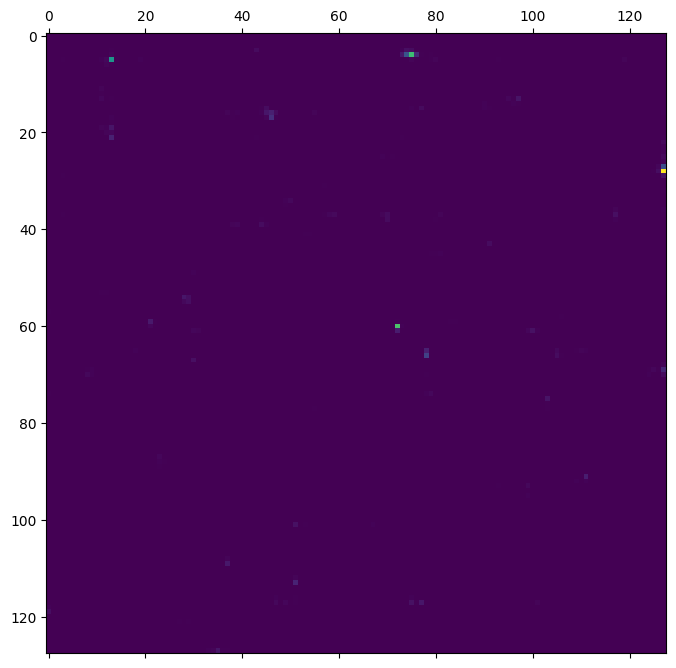

class 1 heatmap


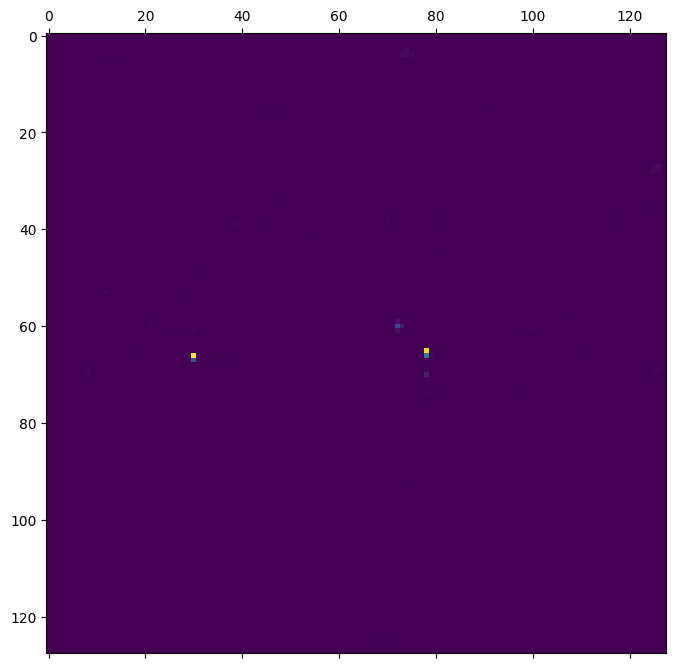

w_heatmap


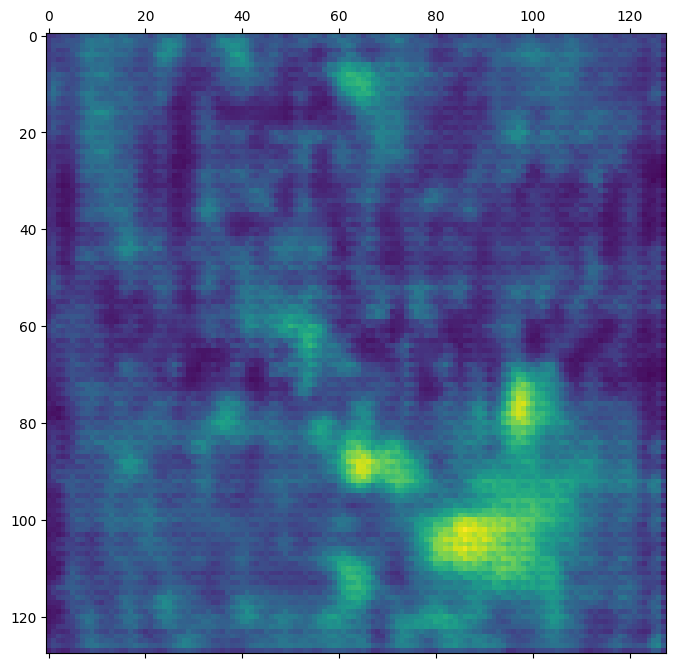

h heatmap


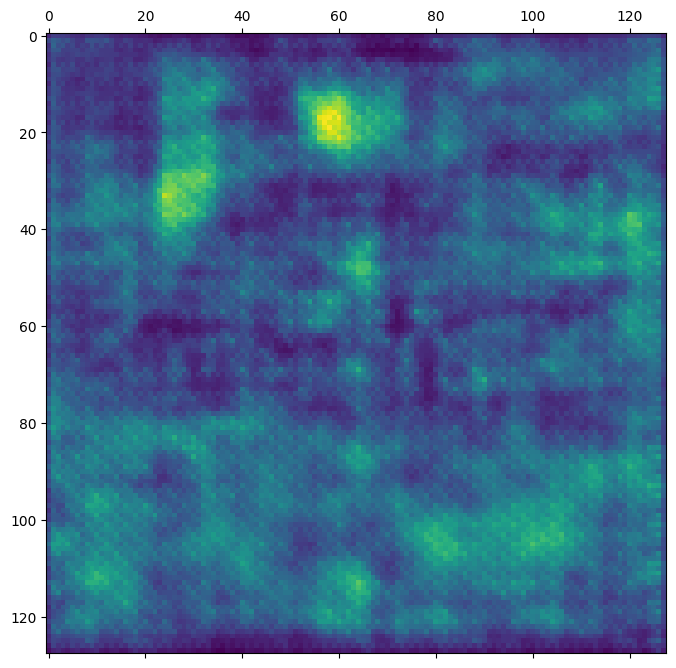

In [24]:
print('class 0 heatmap')
plt.matshow(yp_heat[0][0])
plt.show()

print('class 1 heatmap')
plt.matshow(yp_heat[0][1])
plt.show()

print('w_heatmap')
plt.matshow(yp_heat[0][-1])
plt.show()

print('h heatmap')
plt.matshow(yp_heat[0][-2])
plt.show()

In [25]:
def draw_boxes(image_np, yc_t, xc_t, hy_t, wx_t, color=(0, 255, 0), thick=1):
    img = np.array(image_np)
    num_boxes = len(yc_t)
    val = np.array(color)
    for idx in range(num_boxes):
        yc = yc_t[idx]
        xc = xc_t[idx]
        hy = hy_t[idx]
        wx = wx_t[idx]

        hyd2 = torch.div(hy, 2, rounding_mode='trunc')
        wxd2 = torch.div(wx, 2, rounding_mode='trunc')

        img[
                yc - hyd2 - thick : yc - hyd2 + thick, 
                xc - wxd2 : xc + wxd2, 
        ] = val
        img[
                yc + hyd2 - thick : yc + hyd2 + thick, 
                xc - wxd2 : xc + wxd2, 
        ] = val

        img[
                yc - hyd2 : yc + hyd2, 
                (xc - wxd2 - thick): (xc - wxd2 + thick), 
        ] = val
        img[
                yc - hyd2 : yc + hyd2, 
                xc + wxd2 - thick: xc + wxd2 + thick, 
        ] = val
    return img


rnd = lambda x: torch.round(x).long()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


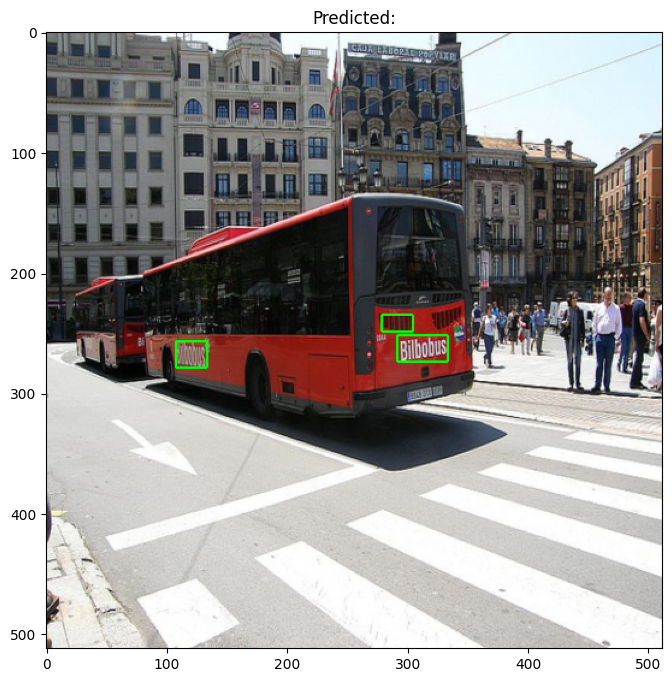

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


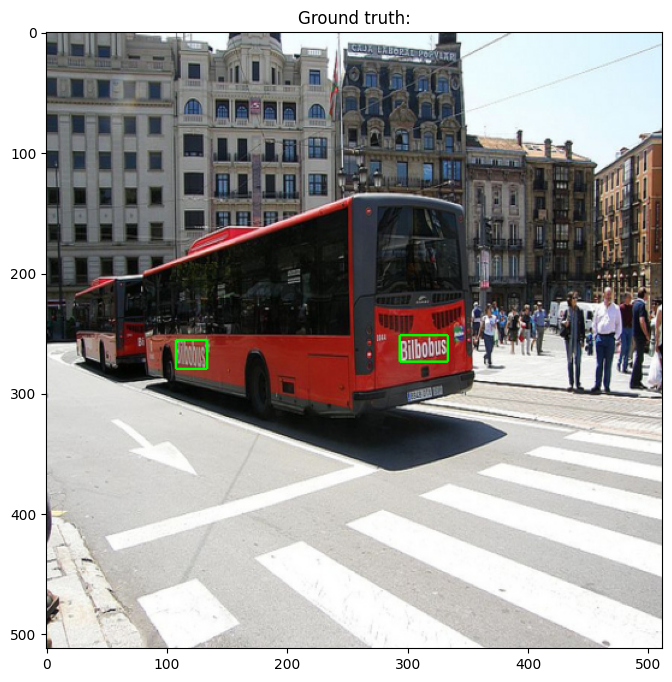

In [26]:
plt.imshow(draw_boxes(
    x.permute(1, 2, 0).numpy(), rnd(yp[0, :3, 0]), rnd(yp[0, :3, 1]), rnd(yp[0, :3, 2]), rnd(yp[0, :3, 3]) 
))
plt.title('Predicted:')
plt.show()
plt.imshow(draw_boxes(
    x.permute(1, 2, 0).numpy(), rnd(y[:, 0]), rnd(y[:, 1]), rnd(y[:, 2]), rnd(y[:, 3]) 
))
plt.title('Ground truth:')
plt.show()

In [27]:
print(yp[0][:2], y[:2])

tensor([[267.6980, 121.3037,  22.3649,  25.6794,   1.0000,   0.9668],
        [263.0141, 313.3056,  23.0446,  41.5517,   1.0000,   0.9207]]) tensor([[267.7867, 121.1200,  25.0667,  26.8800,   1.0000,   1.0000],
        [263.0400, 313.5600,  23.0400,  39.7600,   1.0000,   1.0000]])


## Saving to json

In [28]:
#net = torch.load('centernet_resnet34_512.pth')

In [29]:
def postprocess(data, target_shape, input_shape):
    unf = {}
    res = data[data[:, -1] != 0]
    boxes = res[:, :4].copy()
    b = boxes.copy()
    result_boxes = np.zeros_like(boxes)
    result_boxes[:, 0] = (boxes[:, 1] - b[:, 3] / 2) * (target_shape[1] / input_shape[1])
    result_boxes[:, 1] = (boxes[:, 0] - b[:, 2] / 2) * (target_shape[0] / input_shape[0])
    result_boxes[:, 2] = boxes[:, 3] * (target_shape[1] / input_shape[1])
    result_boxes[:, 3] = boxes[:, 2] * (target_shape[0] / input_shape[0])
    unf['boxes'] = result_boxes
    unf['scores'] = res[:, -1]
    return unf


def extract_results():
    prepared_preds = []
    img_ids = []

    net.eval()

    for num, img_id in enumerate(tqdm(ds_val.ids)):
        img_id = int(img_id)
        img_meta = ct.loadImgs(ids=[img_id])[0]

        with torch.no_grad():
            x = ds_val[num][0]
            
            pred = net(
                x[None, ...].to(device),
                return_objects=True
            )[0].detach().cpu().numpy()
            prepared_preds.append(
                postprocess(pred, target_shape=(img_meta['height'], img_meta['width']), input_shape=input_shape)
            )
            img_ids.append(img_id)

    scores = np.concatenate([u['scores'] for u in prepared_preds], axis=0)
    boxes = np.concatenate([u['boxes'] for u in prepared_preds], axis=0)
    
    image_ids = []
    
    for num, i in enumerate(img_ids):
        image_ids += [i] * len(prepared_preds[num]['boxes'])
    image_ids = np.array(image_ids)

    dump_detections_to_cocotext_json(
        image_ids = image_ids.tolist(),
        xlefts=boxes[:, 0].tolist(),
        ytops=boxes[:, 1].tolist(),
        widths=boxes[:, 2].tolist(),
        heights=boxes[:, 3].tolist(),
        scores=scores.tolist(),
        path=f'predictions.json'
    )
    
    ap, prec, rec = evaluate_ap_from_cocotext_json(
    coco_text=ct,
    path=f'predictions.json'
    )
    return (ap, prec, rec, len(scores))

# Best AP

100%|████████████████████████████████████████████████████████████████████| 4446/4446 [01:28<00:00, 50.05it/s]


Loading and preparing results...     
DONE (t=0.29s)
Итоговый скор AP на val: 0.3372722316387731


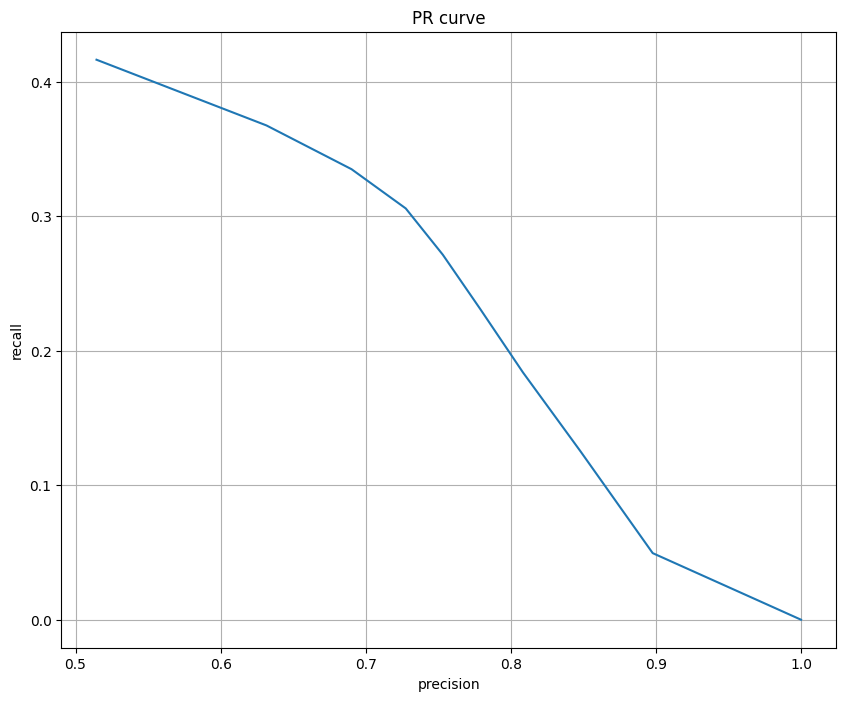

In [30]:
ap, prec, rec, n_obj = extract_results()

print(f"Итоговый скор AP на val: {ap}")

plt.plot(prec, rec)
plt.xlabel('precision')
plt.ylabel('recall')
plt.title('PR curve')
plt.grid()

In [31]:
n_obj

12489

In [ ]:
rec